# Librerie

In [2486]:
import time
import seaborn as sns

import numpy as np
from scipy import stats
from itertools import product

import pandas as pd
from pandas.api.types import is_numeric_dtype

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay, classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
from sklearn.decomposition import PCA

# Models
from sklearn import svm
from sklearn.naive_bayes import CategoricalNB
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Neural Network
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, RMSprop

import tensorflow as tf
from tensorflow.keras.utils import plot_model

# link to google drive to obtain and read the datasets
from google.colab import drive
drive.mount('/content/drive/')
path_to_dataset = 'drive/MyDrive/Appunti Università/Magistrale/Machine Learning/Progetto/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Importazione del training set e test set

Leggo e stampo il dataset di training. Esso contiene tutte le partite di tennis in singolo maschile svolte nel 2023

In [2487]:
train_df = pd.read_csv(path_to_dataset + 'train_2023.csv', sep=',')
train_df.head()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,Lsets,Comment,B365W,B365L,PSW,PSL,MaxW,MaxL,AvgW,AvgL
0,1,Adelaide,Adelaide International 1,01/01/2023,ATP250,Outdoor,Hard,1st Round,3,Giron M.,...,1.0,Completed,1.91,1.91,1.93,1.95,1.99,1.95,1.89,1.89
1,1,Adelaide,Adelaide International 1,01/01/2023,ATP250,Outdoor,Hard,1st Round,3,Mcdonald M.,...,0.0,Retired,1.36,3.20,1.39,3.25,1.44,3.40,1.36,3.12
2,1,Adelaide,Adelaide International 1,02/01/2023,ATP250,Outdoor,Hard,1st Round,3,Kecmanovic M.,...,0.0,Completed,1.57,2.38,1.58,2.53,1.64,2.53,1.58,2.36
3,1,Adelaide,Adelaide International 1,02/01/2023,ATP250,Outdoor,Hard,1st Round,3,Nishioka Y.,...,1.0,Completed,3.75,1.29,4.00,1.28,4.00,1.31,3.56,1.29
4,1,Adelaide,Adelaide International 1,02/01/2023,ATP250,Outdoor,Hard,1st Round,3,Popyrin A.,...,0.0,Completed,6.50,1.11,6.20,1.15,6.75,1.18,6.04,1.13


Leggo e stampo il dataset di test. Leggo e stampo il dataset di training. Esso contiene tutte le partite di tennis in singolo maschile svolte nel 2024

In [2488]:
test_df = pd.read_csv(path_to_dataset + 'test_2024.csv', sep=',')
test_df.head()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,Lsets,Comment,B365W,B365L,PSW,PSL,MaxW,MaxL,AvgW,AvgL
0,1,Brisbane,Brisbane International,31/12/2023,ATP250,Outdoor,Hard,1st Round,3,Popyrin A.,...,1.0,Completed,1.62,2.30,1.72,2.23,1.77,2.32,1.68,2.17
1,1,Brisbane,Brisbane International,31/12/2023,ATP250,Outdoor,Hard,1st Round,3,Shevchenko A.,...,0.0,Completed,1.62,2.30,1.78,2.14,1.78,2.32,1.70,2.14
2,1,Brisbane,Brisbane International,01/01/2024,ATP250,Outdoor,Hard,1st Round,3,Safiullin R.,...,1.0,Completed,2.30,1.62,2.31,1.68,2.32,1.68,2.24,1.63
3,1,Brisbane,Brisbane International,01/01/2024,ATP250,Outdoor,Hard,1st Round,3,Rune H.,...,1.0,Completed,1.25,4.00,1.32,3.68,1.32,4.01,1.28,3.65
4,1,Brisbane,Brisbane International,01/01/2024,ATP250,Outdoor,Hard,1st Round,3,Dimitrov G.,...,1.0,Completed,1.33,3.40,1.35,3.47,1.36,3.50,1.33,3.25


# Aggiutamento del dataset

Vengono convertite le colonne del dataset di partenza. In particolare vengono messi in minuscolo tutti i nomi delle colonne e sostituiti gli spazi con il carattere '_'. Inoltre, convertiamo i prefissi *winner* e *loser* con *player_1* e *player_2*. questo ci permette di apportare 2 modifiche sostanziali:

1.   Ora tutte le colonne associate ad un certo giocatore hanno lo stesso prefisso della colonna stessa. cioè le colonne associate a *player_1* iniziano con questo prefisso (Questo tornerà utile in alcune modifiche effettuate più avanti).

2.   Possiamo aggiungere una colonna **target** denominata *winner*. che conterrà 0 se il *player_1* vincerà, 1 altrimenti.



In [2489]:
def rename_columns(df):
   columns_new_names = {
       'ATP': 'atp',
       'Location': 'location',
       'Tournament': 'tournament',
       'Date': 'date',
       'Series': 'series',
       'Court': 'court',
       'Surface': 'surface',
       'Round': 'round',
       'Best of': 'best_of',
       'Winner': 'player_1',
       'Loser': 'player_2',
       'WRank': 'player_1_rank',
       'LRank': 'player_2_rank',
       'WPts': 'player_1_points',
       'LPts': 'player_2_points',
       'W1': 'player_1_set_1',
       'L1': 'player_2_set_1',
       'W2': 'player_1_set_2',
       'L2': 'player_2_set_2',
       'W3': 'player_1_set_3',
       'L3': 'player_2_set_3',
       'W4': 'player_1_set_4',
       'L4': 'player_2_set_4',
       'W5': 'player_1_set_5',
       'L5': 'player_2_set_5',
       'Wsets': 'player_1_winner_sets',
       'Lsets': 'player_2_winner_sets',
       'Comment': 'comment',
       'B365W': 'player_1_bet365',
       'B365L': 'player_2_bet365',
       'PSW': 'player_1_pinnacle',
       'PSL': 'player_2_pinnacle',
       'MaxW': 'player_1_max',
       'MaxL': 'player_2_max',
       'AvgW': 'player_1_avg',
       'AvgL': 'player_2_avg'
   }

   return df.rename(columns=columns_new_names)

train_df = rename_columns(train_df)
test_df = rename_columns(test_df)

All'interno di questo progetto è stato deciso di tenere solamente i tornei del **Grande Slam**. Questo perchè sono considerati i torne più prestigiosi per la classifica ATP, quindi i risultati contenuti sono ritenuti più precisi e "realistici".

In [2490]:
def filter_grand_slam(df):
    filtered = df[df['series'] == 'Grand Slam']

    filtered.reset_index(drop=True, inplace=True)
    filtered.index = range(1, len(filtered) + 1)

    return filtered

train_df = filter_grand_slam(train_df)
test_df = filter_grand_slam(test_df)

In questo passaggio eliminiamo alcune colonne dal dataset. Questi attributi sono stati eliminati per diversi motivi, tra cui:


*   Alcune colonne contenevano per la grande maggioranza lo stesso valore, tranne poche occorrenze. Quindi non sono state considerate valide per il training.

*   Alcune colonne non contengono dati utili, oppure contengono dati che non sono disponibili a priori diuna partita (quindi il progetto perderebbe di senso)

la lista *cols_to_keep* contiene le colonne da tenere.

In [2491]:
def keep_columns(df):
    cols_to_keep = [
        'tournament', 'surface', 'round',
        'player_1', 'player_2', 'player_1_rank', 'player_2_rank',
        'player_1_bet365', 'player_2_bet365',
        'player_1_pinnacle', 'player_2_pinnacle'
    ]

    return df[cols_to_keep]

train_df = keep_columns(train_df)
test_df = keep_columns(test_df)

Alcune righe (istanze) del dataset contengono dei valori **null**. Non per forza l'intera riga.

Per questo è stato creato un metodo per eliminare queste righe, se l'attributo null è in una delle colonne citate nella lista *cols_to_check*.

Se il valore nullo è contenuto nella colonna che contiene il ranking ATP, viene considerato il massimo valore presente. A questo si aggiunge +1 e il valore viene salvato nelle caselle null. Questo perché un giocatore con un rank ATP null è considerato fuori dalla classifica ATP e quindi più "scarso" di quello con il valore più grande.

In [2492]:
def manage_nulls(df):
    df = df.apply(handle_nulls, axis=1, args=(df,))

    cols_to_check = [
        'tournament', 'surface', 'round',
        'player_1', 'player_2',
        'player_1_bet365', 'player_2_bet365',
        'player_1_pinnacle', 'player_2_pinnacle'
    ]
    df = df.dropna(subset=cols_to_check)

    return df

def handle_nulls(row, df):
    max_rank = df[['player_1_rank', 'player_2_rank']].max().max()
    if pd.isnull(row['player_1_rank']):
        row['player_1_rank'] = max_rank + 1
    elif pd.isnull(row['player_2_rank']):
        row['player_2_rank'] = max_rank + 1

    return row

train_df = manage_nulls(train_df)
test_df = manage_nulls(test_df)

In [2493]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507 entries, 1 to 508
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tournament         507 non-null    object 
 1   surface            507 non-null    object 
 2   round              507 non-null    object 
 3   player_1           507 non-null    object 
 4   player_2           507 non-null    object 
 5   player_1_rank      507 non-null    float64
 6   player_2_rank      507 non-null    float64
 7   player_1_bet365    507 non-null    float64
 8   player_2_bet365    507 non-null    float64
 9   player_1_pinnacle  507 non-null    float64
 10  player_2_pinnacle  507 non-null    float64
dtypes: float64(6), object(5)
memory usage: 47.5+ KB


In [2494]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 1 to 127
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tournament         127 non-null    object 
 1   surface            127 non-null    object 
 2   round              127 non-null    object 
 3   player_1           127 non-null    object 
 4   player_2           127 non-null    object 
 5   player_1_rank      127 non-null    int64  
 6   player_2_rank      127 non-null    float64
 7   player_1_bet365    127 non-null    float64
 8   player_2_bet365    127 non-null    float64
 9   player_1_pinnacle  127 non-null    float64
 10  player_2_pinnacle  127 non-null    float64
dtypes: float64(5), int64(1), object(5)
memory usage: 11.0+ KB


Viene aggiunta la colonna target *winner*. Inizialmente contiene sempre 1 perchè tutti i vincitori sono nella colonna *player_1*

In [2495]:
def add_winner_column(df):
    df['winner'] = 0
    return df

train_df = add_winner_column(train_df)
test_df = add_winner_column(test_df)

In questo momento prendiamo metà del dataset. Di questa parte selezionata scambiamo i valori di *player_1* e *player_2* (insieme a tutti gli attributi associati). questo per evitare che il modello "pensi cose strane" per via del fatto che il valore del target sarebbe stato sempre 1 e il vincitore in "player_1".

In questo modo "mescoliamo" leggermente il dataset.

In [2496]:
def swap_players(df):
    swap_rows = df.index[::2]

    df_swapped = df.loc[swap_rows]
    df_swapped['player_1'], df_swapped['player_2'] = df_swapped['player_2'], df_swapped['player_1']
    df_swapped['winner'] = 1

    for col in df.columns:
        if col.startswith('player_1_'):
            df_swapped[col], df_swapped[col.replace('player_1_', 'player_2_')] = df_swapped[col.replace('player_1_', 'player_2_')], df_swapped[col]

    df_new = pd.concat([df.loc[~df.index.isin(swap_rows)], df_swapped])
    return df_new

train_df = swap_players(train_df)
test_df = swap_players(test_df)

Manca solo un utlimo passaggio. Potrebbe accadere che un certo giocatore appaia nel **test set** ma non nel **train set**. Questo è un problema in quanto di quel giocatore non abbiamo dati e quindi non possiamo effettuare predizioni su di lui. Quindi quando notiamo questa problematica eliminiamo dal train set l'istanza corrispondente.

In [2497]:
def filter_test_df(train_df, test_df):
    player_names = set(train_df['player_1'].tolist() + train_df['player_2'].tolist())
    test_filtered = test_df[(test_df['player_1'].isin(player_names)) & (test_df['player_2'].isin(player_names))]

    return test_filtered

test_df = filter_test_df(train_df, test_df)

Quindi otteniamo i seguenti dataset

In [2498]:
train_df

,tournament,surface,round,player_1,player_2,player_1_rank,player_2_rank,player_1_bet365,player_2_bet365,player_1_pinnacle,player_2_pinnacle,winner
2,Australian Open,Hard,1st Round,Watanuki Y.,Rinderknech A.,138.0,59.0,2.30,1.62,2.18,1.77,0
4,Australian Open,Hard,1st Round,Etcheverry T.,Barrere G.,79.0,83.0,2.30,1.62,2.43,1.63,0
6,Australian Open,Hard,1st Round,Cerundolo F.,Pella G.,29.0,181.0,1.13,6.00,1.17,6.06,0
8,Australian Open,Hard,1st Round,Hurkacz H.,Martinez P.,11.0,60.0,1.06,10.00,1.06,13.22,0
10,Australian Open,Hard,1st Round,Nishioka Y.,Ymer M.,33.0,69.0,1.91,1.91,2.02,1.88,0
...,...,...,...,...,...,...,...,...,...,...,...,...
500,US Open,Hard,4th Round,De Minaur A.,Medvedev D.,13.0,3.0,3.20,1.36,3.35,1.38,1
502,US Open,Hard,Quarterfinals,Fritz T.,Djokovic N.,9.0,2.0,6.00,1.13,6.80,1.14,1
504,US Open,Hard,Quarterfinals,Rublev A.,Medvedev D.,8.0,3.0,3.20,1.36,3.30,1.39,1
506,US Open,Hard,Semifinals,Shelton B.,Djokovic N.,47.0,2.0,10.00,1.06,9.76,1.09,1


In [2499]:
test_df

,tournament,surface,round,player_1,player_2,player_1_rank,player_2_rank,player_1_bet365,player_2_bet365,player_1_pinnacle,player_2_pinnacle,winner
2,Australian Open,Hard,1st Round,Munar J.,Shevchenko A.,82.0,48.0,3.20,1.36,3.06,1.43,0
4,Australian Open,Hard,1st Round,Kotov P.,Rinderknech A.,65.0,94.0,1.62,2.30,1.69,2.30,0
8,Australian Open,Hard,1st Round,Machac T.,Mochizuki S.,75.0,136.0,1.25,4.00,1.30,3.92,0
12,Australian Open,Hard,1st Round,Fritz T.,Diaz Acosta F.,12.0,90.0,1.03,15.00,1.04,17.97,0
14,Australian Open,Hard,1st Round,Halys Q.,Harris L.,110.0,167.0,3.20,1.36,3.59,1.34,0
...,...,...,...,...,...,...,...,...,...,...,...,...
119,Australian Open,Hard,4th Round,Norrie C.,Zverev A.,22.0,6.0,4.00,1.25,4.46,1.25,1
121,Australian Open,Hard,Quarterfinals,Fritz T.,Djokovic N.,12.0,1.0,7.00,1.10,8.55,1.11,1
123,Australian Open,Hard,Quarterfinals,Hurkacz H.,Medvedev D.,9.0,3.0,3.00,1.40,3.14,1.42,1
125,Australian Open,Hard,Semifinals,Djokovic N.,Sinner J.,1.0,4.0,1.50,2.63,1.54,2.66,1


# PCA

In [2500]:
numeric_columns = [col for col in train_df.columns if is_numeric_dtype(train_df[col])]
numeric_columns

['player_1_rank',
 'player_2_rank',
 'player_1_bet365',
 'player_2_bet365',
 'player_1_pinnacle',
 'player_2_pinnacle',
 'winner']

Rimuoviamo la colonna target che non è necessaria

In [2501]:
numeric_columns.remove('winner')
numeric_columns

['player_1_rank',
 'player_2_rank',
 'player_1_bet365',
 'player_2_bet365',
 'player_1_pinnacle',
 'player_2_pinnacle']

In [2502]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(train_df[numeric_columns])
scaled_data

array([[ 0.5716055 , -0.16906083, -0.20729903, -0.41616517, -0.2719543 ,
        -0.37400836],
       [ 0.02002528,  0.1068791 , -0.20729903, -0.41616517, -0.21977178,
        -0.39752198],
       [-0.44741559,  1.23363382, -0.47064702,  0.51755749, -0.48277169,
         0.34651618],
       ...,
       [-0.64374075, -0.81292067, -0.00472365, -0.47159163, -0.03817661,
        -0.43783105],
       [-0.27913688, -0.82441817,  1.52584586, -0.53554523,  1.31021973,
        -0.48821738],
       [-0.69048484, -0.82441817, -0.07675045, -0.45453733, -0.11123214,
        -0.42607424]])

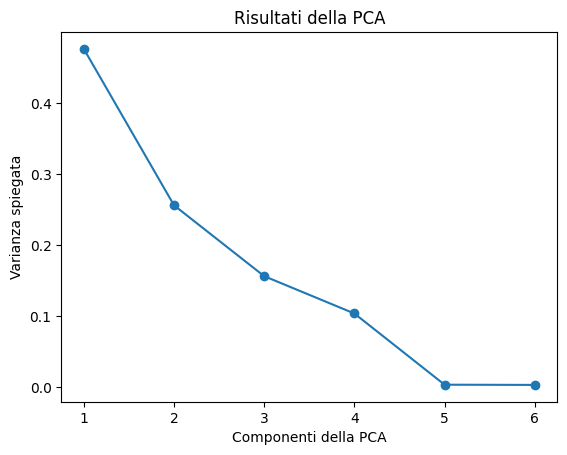

In [2503]:
pca = PCA().fit(scaled_data)

plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Componenti della PCA')
plt.ylabel('Varianza spiegata')
plt.title("Risultati della PCA")
plt.show()

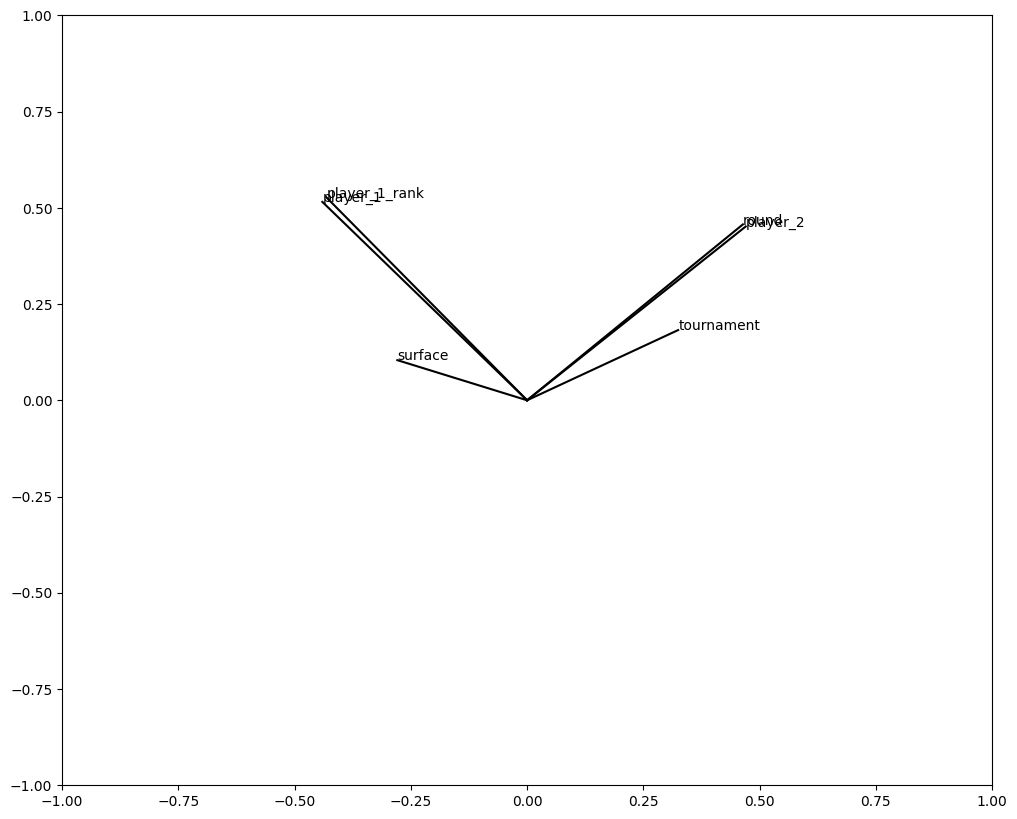

In [2504]:
pca = PCA(n_components=6).fit(scaled_data)

pcs = pca.components_
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # plot line between origin and point (x, y)
    ax.plot([0, x], [0, y], color='k')
    # display the label of the point
    ax.text(x, y, train_df.columns[i], fontsize='10')

# Adattamento del dataset per i modelli

In questa sezione vengono effettuate alcune revisioni al dataset per permettere ai modelli di poterci lavorare sopra correttamente.

Prendo tutte le colonne che contengono stringhe (o comunque non numeri) e le elenco all'interno della lista *to_categorical*. Queste colonne verranno mappate in pandas come **categorie** (dtype).

In [2505]:
to_categorical = ['tournament', 'surface', 'round', 'player_1', 'player_2']
for category in to_categorical:
  train_df[category] = train_df[category].astype('category')
  test_df[category] = test_df[category].astype('category')

Ora stiamo mappando tutte le categorie con dei numeri. Lo facciamo sia per il dataset di training che di test.

---

Per ottenere una mappatura corretta facciamo in modo che una certa categoria venga mappata nello stesso modo in entrambi i dataset. Ad esempio:

train: "Pippo" -> 1  allora test: "Pippo" -> 1 (in una certa colonna)

---

Le colonne "player_1" e "player_2" contengono i nomi dei giocatori e questi devono essere mappati allo stesso modo in entrambe le colonne.

In [2506]:
# create a dictionary to store the mappings for each column
mappings = {}

# convert the training dataset
label_encoder = LabelEncoder()
for col in to_categorical:
  if col != 'player_1' and col != 'player_2':
    train_df[col] = label_encoder.fit_transform(train_df[col])
    mappings[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# convert the test dataset
for col in to_categorical:
  if col != 'player_1' and col != 'player_2':
    test_df[col] = [mappings[col].get(x, -1) for x in test_df[col]]

# convert the player columns in the training dataset
names = pd.concat([train_df['player_1'], train_df['player_2']]).unique()
label_encoder.fit(names)
train_df['player_1'] = label_encoder.transform(train_df['player_1'])
train_df['player_2'] = label_encoder.transform(train_df['player_2'])

# convert the player columns in the test dataset
test_df['player_1'] = label_encoder.transform(test_df['player_1'])
test_df['player_2'] = label_encoder.transform(test_df['player_2'])

# Tuning dei parametri

Effettuo la cross-validation per cercare i migliori parametri per il modello definitivo (tuning)

In [2507]:
target_name = 'winner'
feature_names = [col for col in train_df.columns.tolist() if col != target_name]


# X contains feature to train/test (test is for cross-validation)
# Y contains target
X_train, X_test, y_train, y_test = train_test_split(train_df[feature_names], train_df[target_name], test_size=0.3, random_state=42)

Imposto i vari parametri da controllare per il tuning. Insieme ai valori che possono assumere

In [2508]:
def float_range(start, end, step=0.1):
    result = []
    i = start
    while i < end:
        result.append(round(i, 1))
        i += step
    return result

tree_param_grid = {
    # General
    'criterion': ['gini', 'entropy'],
    'random_state': [None, 42],
    'splitter': ['random', 'best'],

    # Max
    'max_features': [None, 'sqrt', 'log2'] + np.arange(1, 10).tolist(),

    # Min
    'min_samples_split': np.arange(2, 10).tolist(),
    'min_samples_leaf': np.arange(1, 10).tolist(),
    'min_weight_fraction_leaf': float_range(0.0, 0.5),
    'min_impurity_decrease': float_range(0.0, 0.5),
}

naive_param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 3.0, 5.0],
    'force_alpha': [True, False],
    'fit_prior': [True, False],
}

Questa sezione permette di fare tuning sui dati e trovare le migliori combinazioni per il *DecisionTreeClassifier*.

Esistono sostanzialmente due modi:
1.   GridSearchCV: Esegue una ricerca esaustiva su una griglia di valori predefiniti per i parametri.
2.   RandomizerSearchCV: Esegue una ricerca casuale su un campione di valori per i parametri

In generale GridSearchCV offre un analisi molto esaustiva (in quanto controlla tutte le possibili combinazioni) ma è molto costoso a livello computazionale. Viceversa il RandomizerSearchCV.

In [2509]:
# decision_tree_classifier_t = DecisionTreeClassifier()
# categorical_naive_t = CategoricalNB()

'''
search = RandomizedSearchCV(
    estimator=<put_mode_here>,
    param_distributions=<put_param_grid_here>,
    cv=10, n_iter=100, n_jobs=-1, verbose=10,
    random_state=42,
    return_train_score=True
)


search = GridSearchCV(
    estimator=<put_mode_here>,
    param_distributions=<put_param_grid_here>,
    cv=10, n_jobs=-1, verbose=10,
    return_train_score=True
)


search.fit(X_train, y_train)

print('Best random search parameters: ', search.best_params_)
print('\n\n')
print('Best random search score: ', search.best_score_)
print('\n\n')
print(search.best_estimator_)
'''

"\nsearch = RandomizedSearchCV(\n    estimator=<put_mode_here>,\n    param_distributions=<put_param_grid_here>,\n    cv=10, n_iter=100, n_jobs=-1, verbose=10,\n    random_state=42,\n    return_train_score=True\n)\n\n\nsearch = GridSearchCV(\n    estimator=<put_mode_here>,\n    param_distributions=<put_param_grid_here>,\n    cv=10, n_jobs=-1, verbose=10,\n    return_train_score=True\n)\n\n\nsearch.fit(X_train, y_train)\n\nprint('Best random search parameters: ', search.best_params_)\nprint('\n\n')\nprint('Best random search score: ', search.best_score_)\nprint('\n\n')\nprint(search.best_estimator_)\n"

## Reti neurali

In [2510]:
scaler = StandardScaler()
X_train[feature_names] = scaler.fit_transform(X_train[feature_names])
X_test[feature_names] = scaler.transform(X_test[feature_names])

In [2511]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [2512]:
param_grid = {
  'batch_size': [10, 15, 20],
  'epochs': [10, 15, 20],
  'secondLayer': [22, 44],
  'thirdLayer': [12, 22],
  'learning_rate': [0.01, 0.01, 0.1],
  'oneMoreLayer': [0, 1]
}

In [2513]:
def firstValue(pred):
  return np.array([tmp[0] for tmp in pred])

In [2514]:
def correctValue(pred):
  for i in range(pred.shape[0]):
    value = pred[i]
    if (value[0] > value[1]):
      pred[i] = [1,0]
    else:
      pred[i] = [0,1]
  return pred

In [2515]:
def create_model(firstLayer=11, secondLayer=11, thirdLayer=11, learning_rate=0.1, oneMoreLayer=0):
    model = Sequential()
    model.add(Dense(firstLayer, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(secondLayer, activation='relu'))
    if(oneMoreLayer == 1):
      model.add(Dense(thirdLayer, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

Togliere i commenti per eseguire il tuning dei parametri

In [2516]:
'''
best_accuracy = 0
best_params = {}
best_model = None

for params in product(*param_grid.values()):

  model = create_model(params[2], params[3], params[4], params[5])
  model.fit(X_train, y_train, batch_size=params[0], epochs=params[1])

  y_pred = model.predict(X_test)
  y_pred = correctValue(y_pred)
  accuracy = accuracy_score(y_test, y_pred)

  print("Hyperparameters: ", params)
  print("Accuracy: ", accuracy)
  print("------------------------------------------------")

  if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_params = params
      best_model = model
      best_batch_size = params[0]
      best_epochs = params[1]

print("Best hyperparameters: ", best_params)
print("Best accuracy: ", best_accuracy)
'''

'\nbest_accuracy = 0\nbest_params = {}\nbest_model = None\n\nfor params in product(*param_grid.values()):\n\n  model = create_model(params[2], params[3], params[4], params[5])\n  model.fit(X_train, y_train, batch_size=params[0], epochs=params[1])\n\n  y_pred = model.predict(X_test)\n  y_pred = correctValue(y_pred)\n  accuracy = accuracy_score(y_test, y_pred)\n\n  print("Hyperparameters: ", params)\n  print("Accuracy: ", accuracy)\n  print("------------------------------------------------")\n\n  if accuracy > best_accuracy:\n      best_accuracy = accuracy\n      best_params = params\n      best_model = model\n      best_batch_size = params[0]\n      best_epochs = params[1]\n\nprint("Best hyperparameters: ", best_params)\nprint("Best accuracy: ", best_accuracy)\n'

# Predizioni

Dopo il tuning vengono creati i vari modelli e mostrati i risultati delle predizioni.

## Albero di decisione

In [2517]:
decision_tree_classifier = DecisionTreeClassifier(
    criterion='gini',
    splitter='best',
    max_features='sqrt',
    min_samples_split=9,
    min_weight_fraction_leaf=0.1,
    random_state=None
)
decision_tree_classifier.fit(train_df[feature_names], train_df[target_name])

# Print decision tree
fig, ax = plt.subplots(figsize=(150, 100))
plot_tree(decision_tree_classifier, filled=True, ax=ax)
plt.plot()

[]

In [2518]:
# Evaluate the model using test data
y_pred_dt = decision_tree_classifier.predict(test_df[feature_names])

print('Test set - Report - Decision tree\n')
print(classification_report(test_df[target_name], y_pred_dt))

Test set - Report - Decision tree

              precision    recall  f1-score   support

           0       0.75      0.68      0.72        57
           1       0.69      0.75      0.72        53

    accuracy                           0.72       110
   macro avg       0.72      0.72      0.72       110
weighted avg       0.72      0.72      0.72       110



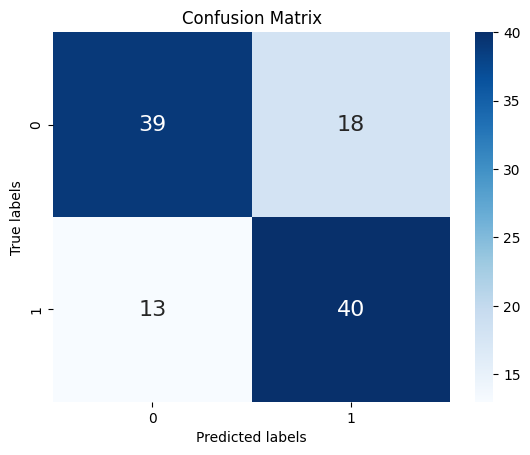

In [2519]:
# Toggle confusion matrix
conf_matrix = confusion_matrix(test_df[target_name], y_pred_dt, labels=None, sample_weight=None)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## (Categorical) Naive Bayes

è stato scelto questa "tipologia" di naive bayes dato il numerevole quantitativo di dati categorici nel dataset

In [2520]:
categorical_naive = CategoricalNB(alpha=0.01)
categorical_naive.fit(train_df[feature_names], train_df[target_name])

CategoricalNB(alpha=0.01)

In [2521]:
# Evaluate the model using test data
y_pred_nb = categorical_naive.predict(test_df[feature_names])

print('Test set - Report - Naive Bayes\n')
print(classification_report(test_df[target_name], y_pred_nb))

Test set - Report - Naive Bayes

              precision    recall  f1-score   support

           0       0.79      0.79      0.79        57
           1       0.77      0.77      0.77        53

    accuracy                           0.78       110
   macro avg       0.78      0.78      0.78       110
weighted avg       0.78      0.78      0.78       110



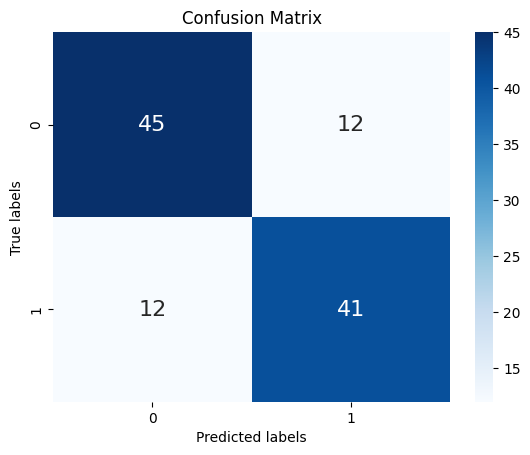

In [2522]:
# Toggle confusion matrix
conf_matrix = confusion_matrix(test_df[target_name], y_pred_nb, labels=None, sample_weight=None)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Rete neurale

In [2523]:
standardScaler = StandardScaler()
X_train_nn = pd.DataFrame(standardScaler.fit_transform(train_df[feature_names]))
X_test_nn = pd.DataFrame(standardScaler.fit_transform(test_df[feature_names]))

In [2524]:
y_train_nn = keras.utils.to_categorical(train_df[target_name])
y_test_nn = keras.utils.to_categorical(test_df[target_name])

In [2525]:
y_test_first = firstValue(y_test_nn)

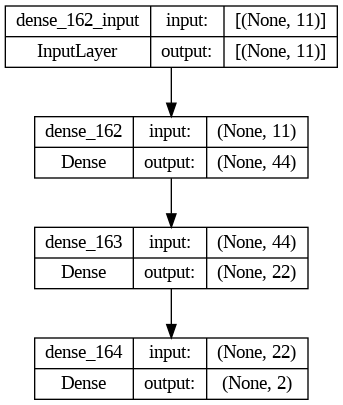

In [2526]:
nn = Sequential()
nn.add(Dense(44, input_dim=X_train_nn.shape[1], activation='relu'))
nn.add(Dense(22, activation='relu'))
nn.add(Dense(2, activation='softmax'))
nn.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics='accuracy')

keras.utils.plot_model(nn, show_shapes=True)

In [2527]:
nn.fit(X_train_nn, y_train_nn, batch_size=15, epochs=20, verbose=1)

Epoch 1/20
34/34 [==============================] - 1s 2ms/step - loss: 0.5922 - accuracy: 0.6785
Epoch 2/20
34/34 [==============================] - 0s 2ms/step - loss: 0.5316 - accuracy: 0.7041
Epoch 3/20
34/34 [==============================] - 0s 3ms/step - loss: 0.5190 - accuracy: 0.7357
Epoch 4/20
34/34 [==============================] - 0s 4ms/step - loss: 0.5093 - accuracy: 0.7475
Epoch 5/20
34/34 [==============================] - 0s 3ms/step - loss: 0.5004 - accuracy: 0.7436
Epoch 6/20
34/34 [==============================] - 0s 3ms/step - loss: 0.5033 - accuracy: 0.7515
Epoch 7/20
34/34 [==============================] - 0s 3ms/step - loss: 0.4897 - accuracy: 0.7535
Epoch 8/20
34/34 [==============================] - 0s 3ms/step - loss: 0.4750 - accuracy: 0.7771
Epoch 9/20
34/34 [==============================] - 0s 3ms/step - loss: 0.4720 - accuracy: 0.7613
Epoch 10/20
34/34 [==============================] - 0s 3ms/step - loss: 0.4672 - accuracy: 0.7771
Epoch 11/20
34/34 [

In [2528]:
y_pred_nn = nn.predict(X_test_nn)
y_pred_nn = correctValue(y_pred_nn)
y_pred_first = firstValue(y_pred_nn)
accuracy = accuracy_score(y_test_nn, y_pred_nn)
print("Accuracy: ", accuracy)

4/4 [==============================] - 0s 4ms/step
Accuracy:  0.7090909090909091


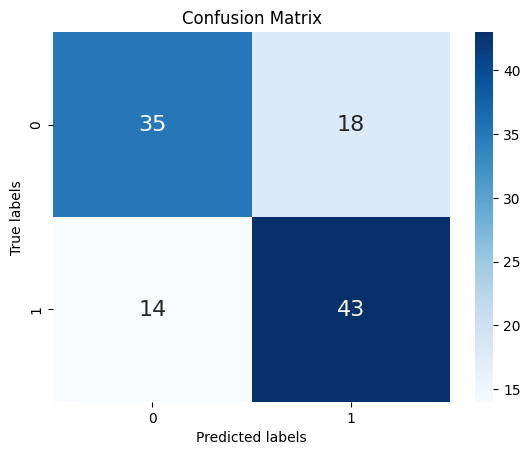

In [2529]:
# Toggle confusion matrix
conf_matrix = confusion_matrix(y_test_first, y_pred_first, labels=None, sample_weight=None)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

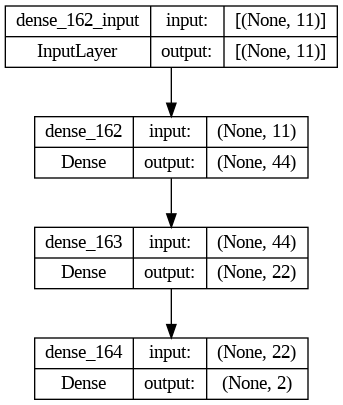

In [2530]:
plot_model(nn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [2531]:
weights = nn.get_weights()

# Visualizza i pesi dei neuroni
for layer_weights in weights:
    print(layer_weights)

[[-1.55900210e-01  3.69515345e-02 -3.51253957e-01 -1.24101505e-01
  -6.75291121e-01  1.14174254e-01  6.34385586e-01 -1.56640440e-01
   4.90469962e-01  1.37259170e-01 -1.65502831e-01 -4.22052473e-01
  -2.53298789e-01  3.98594253e-02 -4.64210734e-02 -4.77630906e-02
  -2.97988594e-01 -4.96585876e-01 -4.79063153e-01  6.26349673e-02
  -1.00354970e-01  4.20099825e-01 -1.25075698e-01 -1.22966103e-01
  -3.51013303e-01 -7.60063946e-01 -8.28203633e-02 -5.86321652e-01
  -6.48437381e-01  4.23969746e-01  2.39506274e-01  3.58725905e-01
   5.57844639e-01  2.73249477e-01  1.39892444e-01  5.53467691e-01
   6.65355980e-01 -2.97025859e-01  4.11495686e-01  4.28124160e-01
   4.38868225e-01 -1.53948469e-02  4.24526423e-01 -4.12021488e-01]
 [-1.79737702e-01  3.46148252e-01 -2.78039366e-01  2.60775834e-01
  -1.24052234e-01  2.52410203e-01  9.28297341e-02  2.20049351e-01
   2.21429631e-01 -4.98989254e-01 -4.21134895e-03  8.45732838e-02
  -7.45455474e-02  5.12441754e-01 -4.28850144e-01 -4.19904292e-01
  -3.0220

# Confronto dei risultati

## Curva ROC

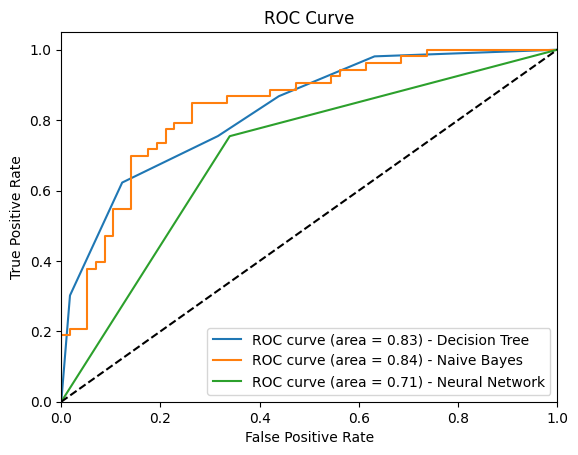

In [2532]:
# Calculate proba
y_pred_prob_dt = decision_tree_classifier.predict_proba(test_df[feature_names])[:, 1]
y_pred_prob_nb = categorical_naive.predict_proba(test_df[feature_names])[:, 1]
y_pred_prob_nn = y_pred_nn

# Check for positive classes
positive_class_dt = decision_tree_classifier.classes_[np.argmax(np.bincount(train_df[target_name]))]
fpr_dt, tpr_dt, thresholds_dt = roc_curve(test_df[target_name], y_pred_prob_dt, pos_label=positive_class_dt)

positive_class_nb = categorical_naive.classes_[np.argmax(np.bincount(train_df[target_name]))]
fpr_nb, tpr_nb, thresholds_nb = roc_curve(test_df[target_name], y_pred_prob_nb, pos_label=positive_class_dt)

fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test_first, y_pred_first)

# Compute AUC
roc_auc_dt = roc_auc_score(test_df[target_name], y_pred_prob_dt)
roc_auc_nb = roc_auc_score(test_df[target_name], y_pred_prob_nb)
roc_auc_nn = roc_auc_score(y_test_nn, y_pred_prob_nn)

# Plot ROC curve
plt.plot(fpr_dt, tpr_dt, label='ROC curve (area = %0.2f) - Decision Tree' % roc_auc_dt)
plt.plot(fpr_nb, tpr_nb, label='ROC curve (area = %0.2f) - Naive Bayes' % roc_auc_nb)
plt.plot(fpr_nn, tpr_nn, label='ROC curve (area = %0.2f) - Neural Network' % roc_auc_nn)

# Print ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()